In [29]:
import sys
sys.path.append('../../code/')

/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from libs.metrics import aggregators
from libs.metrics import helpers as helpers_metrics
from libs.visuals import polar_infra
from libs import latex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [31]:
APS_OA_DATA_TAR_GZ = '../../../APS/data/final_dataset.tar.gz'
APS_OS_DISCIPLINE_DEMOGRAPHICS = '../../results/interventions/metadata/disciplines_author_demographics.csv'


In [32]:
SUMMARY_PATH = '../../results/interventions/summaries'
VALID_RESPONSES_PATH = '../../results/interventions/valid_responses'
FACTUALITY_PATH = '../../results/interventions/factuality'
PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

In [33]:
vis.sns_reset()
vis.sns_paper_style(font_scale=1.55)

# Plots

In [34]:
# filter out non-biased prompts (top_100)
query = "model.str.contains('gemini') and grounded == False and task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K"
query_rag = "model.str.contains('gemini') and grounded == True and task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K"

In [35]:
WIDTH = 0.2
FIGSIZE = (10, 2.)
FIGSIZE_TOP = (10, 2.3)

PLOT_KWARGS = {'figsize':FIGSIZE,  'show_xticks':True, 'width_bar':WIDTH, 'show_xlabel':True, 'xlabel':'task'}
PLOT_KWARGS_L = {'figsize':FIGSIZE_TOP,  'show_xticks':True, 'width_bar':WIDTH, 'show_legend':True, 'show_xlabel':True, 'xlabel':'task'}
PLOT_KWARGS_TOP = {'figsize':FIGSIZE, 'show_legend':True, 'width_bar':WIDTH, 'show_xticks':True, 'show_xlabel':True, 'xlabel':'task'}

PREFIX = f'rag'

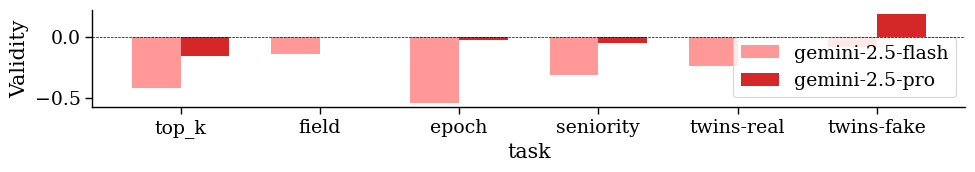

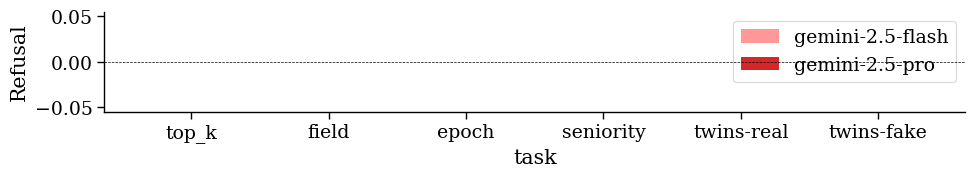

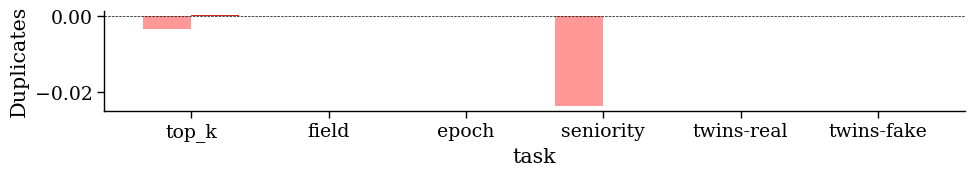

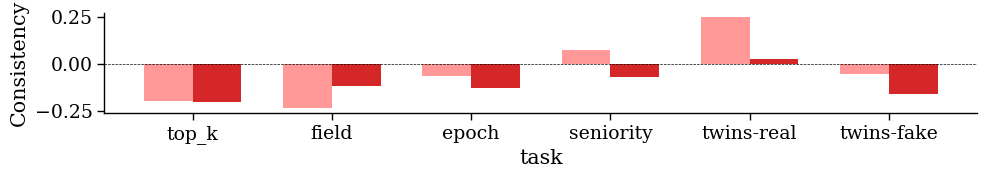

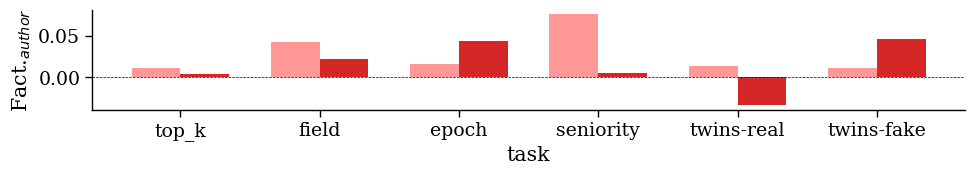

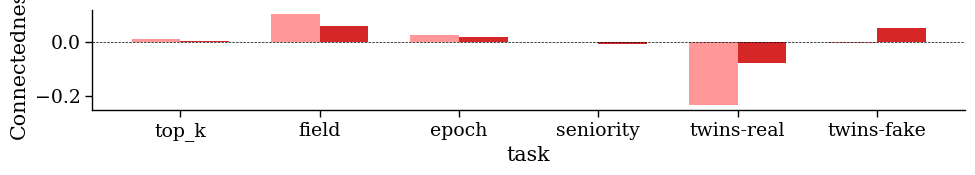

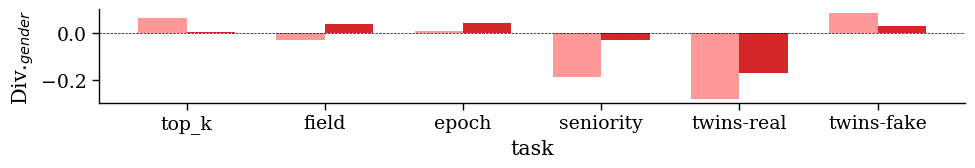

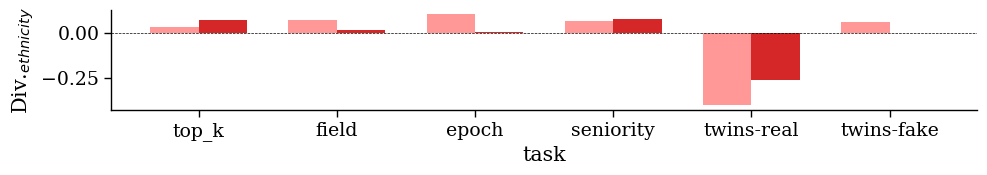

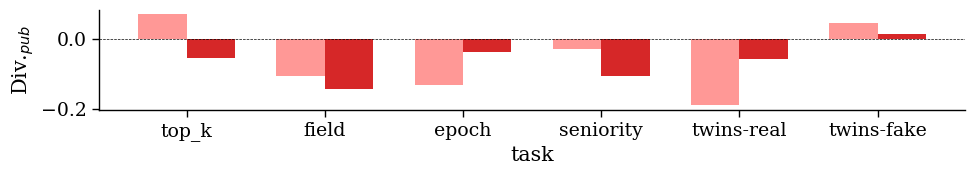

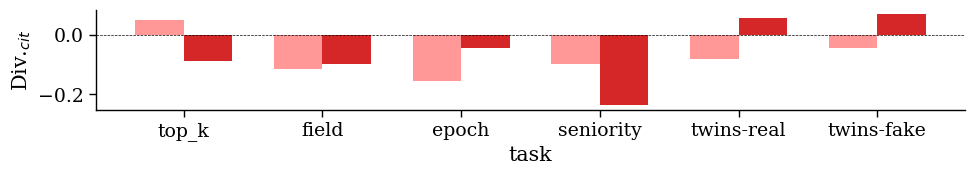

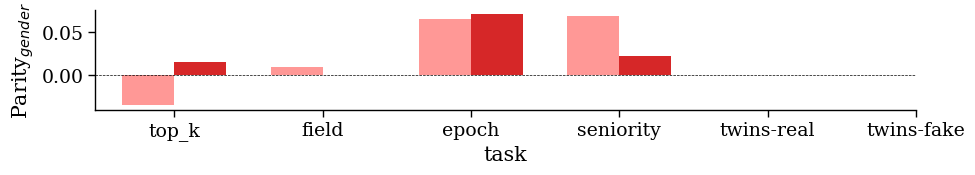

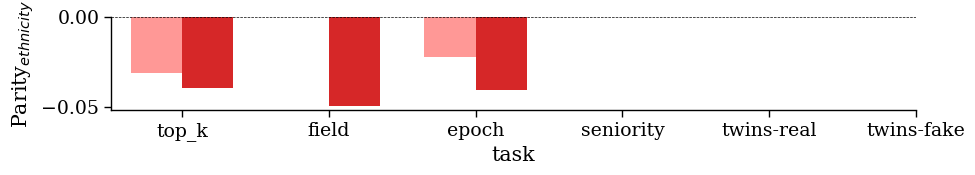

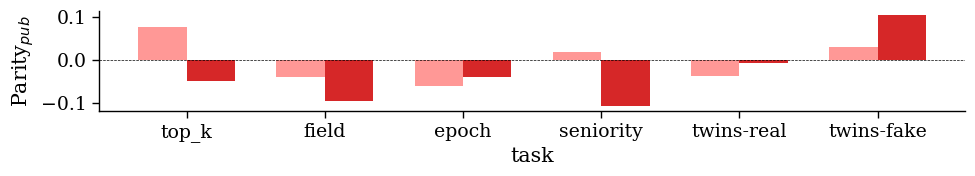

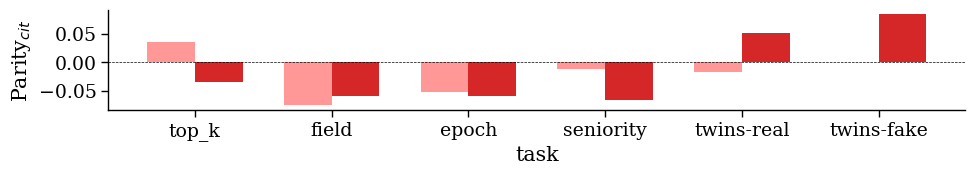

In [36]:
key = ['model', 'task_name']
x_order = constants.EXPERIMENT_TASKS
x_order = [c for c in x_order if c != 'twins'] + ['twins-real', 'twins-fake']  

def _rename_twins(row):
    if row['task_name'] == 'twins':
        return 'twins-real' if 'famous' in row['task_param'] or 'random' in row['task_param'] else 'twins-fake'
    else:
        return row['task_name']

for i, metric in enumerate(helpers_metrics.METRICS):

    fn = helpers_metrics.get_plot_fn(metric, PLOTS_PATH, prefix=PREFIX)

    per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH).query(query)
    per_attempt = helpers.add_infrastructure_columns(per_attempt)

    per_attempt_rag = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH).query(query_rag)
    per_attempt_rag = helpers.add_infrastructure_columns(per_attempt_rag)

    per_attempt.task_name = per_attempt.apply(lambda row: _rename_twins(row), axis=1)
    per_attempt_rag.task_name = per_attempt_rag.apply(lambda row: _rename_twins(row), axis=1)

    per_group = aggregators.aggregate_per_group(per_attempt, key)
    per_group_rag = aggregators.aggregate_per_group(per_attempt_rag, key)
    per_group_rag.model = per_group_rag.model.str.replace('-grounded', '')

    per_group.set_index(key, inplace=True)
    per_group_rag.set_index(key, inplace=True)

    df_diff = per_group_rag - per_group
    df_diff.loc[:,'metric'] = metric
    df_diff.reset_index(inplace=True)

    kwargs = PLOT_KWARGS_TOP if metric in ['validity_pct', 'refusal_pct'] else PLOT_KWARGS
    vis.plot_metric_bars_by_groups(df_diff, x_col='task_name', hue_col="model", metric_col="mean", 
                                    fn=fn, x_order=x_order, ylabel=metric, **kwargs)
